In [2]:
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [10]:
!ls ./../input

gtsrb-german-traffic-sign


In [3]:
dir_data = "./../input/gtsrb-german-traffic-sign"
dir_train = "./../input/gtsrb-german-traffic-sign/Train"
dir_test = "./../input/gtsrb-german-traffic-sign/"

In [4]:
!ls ./../input/gtsrb-german-traffic-sign/Train/
!echo " "
!ls ./../input/gtsrb-german-traffic-sign/Train/ | wc -l

0   11	14  17	2   22	25  28	30  33	36  39	41  6  9
1   12	15  18	20  23	26  29	31  34	37  4	42  7
10  13	16  19	21  24	27  3	32  35	38  40	5   8
 
43


In [5]:
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

In [6]:
print(os.listdir(dir_train))

['7', '17', '19', '22', '2', '35', '23', '10', '5', '36', '20', '27', '41', '39', '32', '25', '42', '8', '38', '12', '0', '31', '34', '18', '28', '16', '13', '26', '15', '3', '1', '30', '14', '4', '9', '21', '40', '6', '11', '37', '33', '29', '24']


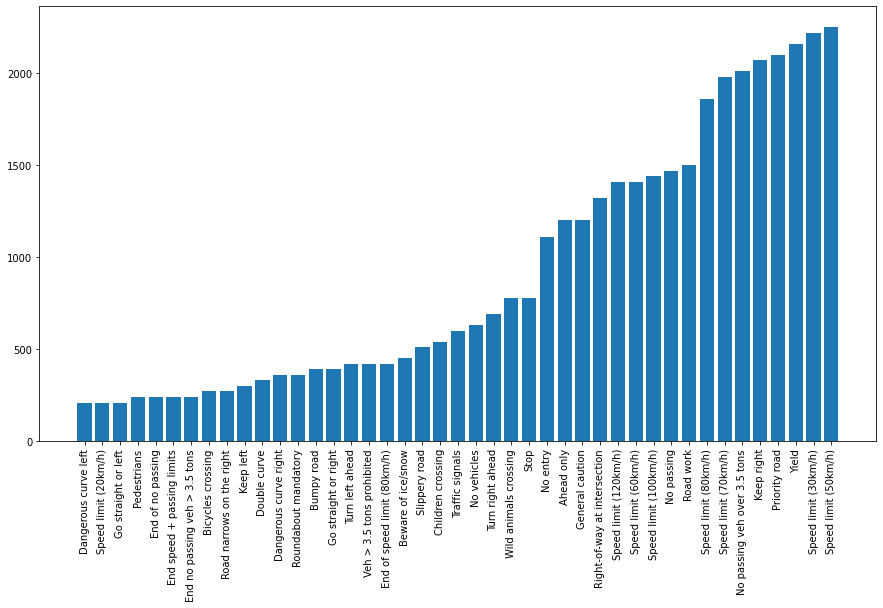

In [7]:
from itertools import zip_longest

folders = os.listdir(dir_train)

train_file_counts = []
class_names = []
temps = []

for folder in folders:
    train_files = os.listdir(dir_train + "/" + folder)
    temp = [
        len(train_files), # file counts
        classes[int(folder)] # class name
    ]
    temps.append(temp)
    
temps.sort(key=lambda x: x[0])
for file_count, class_name in temps:
    train_file_counts.append(file_count)
    class_names.append(class_name)

plt.figure(figsize=(15, 8))
plt.bar(class_names, train_file_counts)
plt.xticks(class_names, rotation='vertical')
plt.show()

In [8]:
image_data = []
image_labels = []

categories = len(os.listdir(dir_train)) # number of cateogories

for i in range(categories):
    path = dir_train + "/" + str(i)
    images_name_list = os.listdir(path)
    
    for image_name in images_name_list:
        image = cv.imread(path + '/' + image_name)
        if image is not None:
            image_from_array = Image.fromarray(image, "RGB")
            resized_image = image_from_array.resize((30, 30))

            image_data.append(np.array(resized_image))
            image_labels.append(i)

In [9]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)

(image_data.shape, image_labels.shape)

((39209, 30, 30, 3), (39209,))

In [10]:
np.random.seed(10)
shuffle_index = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_index)
image_data = image_data[shuffle_index]
image_labels = image_labels[shuffle_index]

In [11]:
x_train, x_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

x_train = np.array(x_train / 255)
x_val = np.array(x_val / 255)

print(
    f"""
    x_train.shape: {x_train.shape}
    x_valid.shape: {x_val.shape}
    y_train.shape: {y_train.shape}
    y_valid.shape: {y_val.shape}
    """
)


    x_train.shape: (27446, 30, 30, 3)
    x_valid.shape: (11763, 30, 30, 3)
    y_train.shape: (27446,)
    y_valid.shape: (11763,)
    


In [12]:
y_train = ks.utils.to_categorical(y_train, categories)
y_val = ks.utils.to_categorical(y_val, categories)

print(
    f"""
    y_train shape: {y_train.shape}
    y_valid_shape: {y_val.shape}
    """
)


    y_train shape: (27446, 43)
    y_valid_shape: (11763, 43)
    


In [19]:
model = ks.models.Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3)),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis = -1),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3)),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis = -1),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3)),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis = -1),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.5),
    
    Dense(43, activation='softmax')
])

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [21]:
tf.test.is_gpu_available()

True

In [23]:
lr = 0.001
epochs = 10

opt = Adam(lr=lr, decay=lr/(epochs * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [24]:
aug = ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

History = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
858/858 [==============================] - 18s 20ms/step - loss: 2.5117 - accuracy: 0.3653 - val_loss: 0.4690 - val_accuracy: 0.8579
Epoch 2/10
858/858 [==============================] - 16s 18ms/step - loss: 0.6749 - accuracy: 0.7882 - val_loss: 0.1732 - val_accuracy: 0.9515
Epoch 3/10
858/858 [==============================] - 16s 19ms/step - loss: 0.3580 - accuracy: 0.8866 - val_loss: 0.1105 - val_accuracy: 0.9700
Epoch 4/10
858/858 [==============================] - 16s 18ms/step - loss: 0.2388 - accuracy: 0.9263 - val_loss: 0.0811 - val_accuracy: 0.9773
Epoch 5/10
858/858 [==============================] - 16s 19ms/step - loss: 0.1871 - accuracy: 0.9404 - val_loss: 0.0654 - val_accuracy: 0.9815
Epoch 6/10
858/858 [==============================] - 16s 18ms/step - loss: 0.1552 - accuracy: 0.9547 - val_loss: 0.0525 - val_accuracy: 0.9842
Epoch 7/10
858/858 [==============================] - 16s 19ms/step - loss: 0.1353 - accuracy: 0.9584 - val_loss: 0.0440 - val_accuracy:

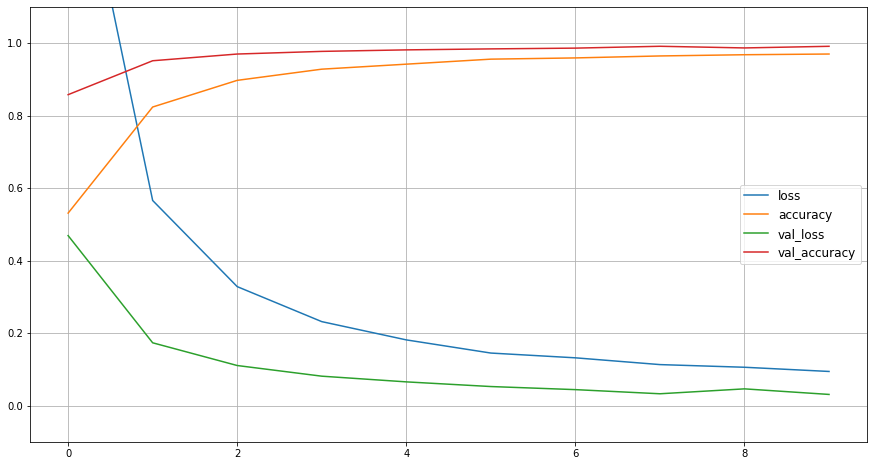

In [25]:
pd.DataFrame(History.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(-0.1, 1.1)
plt.legend(loc="center right", fontsize="large")
plt.show()

In [ ]:
test = pd.read_csv(dir_data + "/Test.csv")

labels = test["ClassId"].values
images = test['Path'].values

data = []

for image in images:
    img = cv.imread(dir_data + "/" + image)
    if img is not None:
        image_from_array = Image.fromarray(img, 'RGB')
        resize_image = image_from_array.resize((30, 30))
        data.append(np.array(resize_image))

x_test = np.array(data)
x_test = x_test / 255

In [ ]:
(x_test.shape)

In [ ]:
pred = model.predict_classes(x_test)

print("test Data accuracy:", accuracy_score(labels, pred) * 100)

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    prediction = pred[i]
    actual = labels[i]
    
    col = 'g'
    if prediction != actual:
        col = 'r'
    
    plt.xlabel(f'Actual={actual} | Pred={prediction}', color=col)
    plt.imshow(x_test[i])
plt.show()

In [29]:
from tensorflow.keras.models import load_model
model.save('my_model.h5')

In [41]:
# model.summary()
!ls

Pickle_RL_Model.pkl  __notebook_source__.ipynb	my_model.h5  test  testt


In [32]:
saved_model = load_model('my_model.h5')

In [33]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 6, 32)          128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)         

In [40]:
## test Image taken from internet
!mkdir ./test
!curl https://cdn-images-1.medium.com/max/1600/1*e0UlsRVfTM2xw_uVWTsPVg.png -o ./test/test1.png
!curl https://toptests.co.uk/wp-content/uploads/2017/04/signs.jpg -o ./test/test2.jpg
!curl https://ih0.redbubble.net/image.13901135.1228/flat,1000x1000,075,f.u1.jpg -o ./test/test3.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  754k  100  754k    0     0  5134k      0 --:--:-- --:--:-- --:--:-- 5134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191k  100  191k    0     0   226k      0 --:--:-- --:--:-- --:--:--  226k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67099  100 67099    0     0   579k      0 --:--:-- --:--:-- --:--:--  579k


In [35]:
!rm -f ./test/test2.png ./test/test3.png

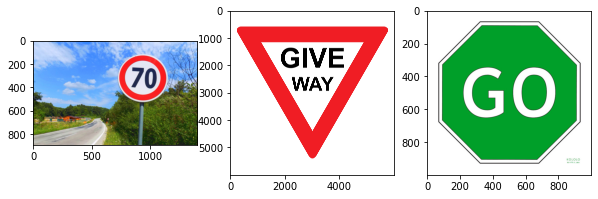

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(10, 20))
ax[0].imshow(plt.imread("./test/test1.png"))
ax[1].imshow(plt.imread("./test/test2.jpg"))
ax[2].imshow(plt.imread("./test/test3.jpg"))

In [ ]:
os.listdir("./test/")

In [45]:
# labels = test["ClassId"].values
testable_images = os.listdir('./test/')

data = []
for image in testable_images:
    img = cv.imread("./test/" + image)
    if img is not None:
        resize_image = cv.resize(img, (30, 30))
        data.append(np.array(resize_image))
    
x_testable = np.array(data)

In [46]:
pred = model.predict_classes(x_testable)

# print("test Data accuracy:", accuracy_score(labels, pred) * 100)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


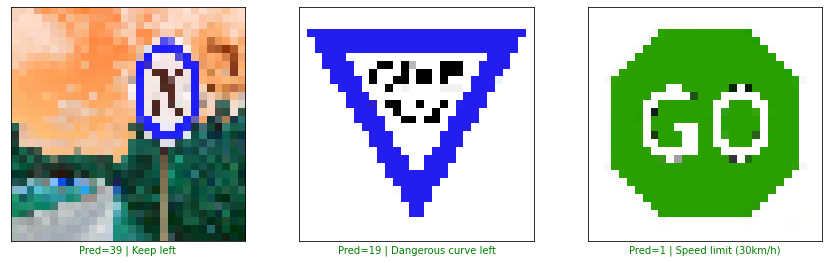

In [47]:
plt.figure(figsize=(25, 25))

for i in range(3):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    prediction = pred[i]
    label = classes[prediction]
    
    col = 'g'
    
    plt.xlabel(f'Pred={prediction} | {label}', color=col)
    plt.imshow(x_testable[i])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 20))
ax[0].imshow(x_testable[0])
ax[1].imshow(x_testable[1])
ax[2].imshow(x_testable[2])